# FairCLIP Reproducibility Notebook

It is not feasible to run all the code in the project in a jupyter notebook, the purpose of this notebook is to showcase the workings of all parts of the paper, therefore simplifications have been made in the amount of epochs/batch samples, it is possible (however not recommended) to turn this off by changing the statement below.

In [51]:
visualization_mode = True

# 1. Dataset

The dataset is the Harvard-FairVLMed Dataset [[1]](#1) from Luo et al. (2024) [[2]](#2).

In [52]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Image

DATA_DIR = Path("./data")
RESULTS_DIR = Path("./results")

The dataset provides data on several features with characteristics relating to fairness, as well as ground truth data on glaucoma diagnosis and a summary of the clinical notes created using GPT-4. 

In [53]:
df = pd.read_csv(DATA_DIR / 'Harvard-FairVLMed/data_summary.csv')
display(df[:10])

,filename,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,data_00001.npz,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,yes,training
1,data_00002.npz,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,yes,training
2,data_00003.npz,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",no,training
3,data_00004.npz,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,yes,training
4,data_00005.npz,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,yes,training
5,data_00006.npz,41.79,female,white,unknown,english,married or partnered,formulation: this patient presents for follow ...,Patient has optic nerve head drusen with no vi...,yes,training
6,data_00007.npz,43.80,male,white,non-hispanic,english,married or partnered,without loss of consciousness. since then he p...,Patient reports worsened vision and right peri...,yes,training
7,data_00008.npz,70.21,male,white,non-hispanic,english,single,DATE_TIME. m referred by dr. PERSON for glauco...,The patient was referred for glaucoma and cata...,yes,training
8,data_00009.npz,86.58,female,white,non-hispanic,english,widowed,right eye: superior > inferior thinning retina...,"The patient, an 86 y.o. female, has primary op...",yes,training
9,data_00010.npz,29.89,female,white,non-hispanic,english,single,the exam DATE_TIME showed significant improvem...,Patient showed significant improvement in left...,yes,training


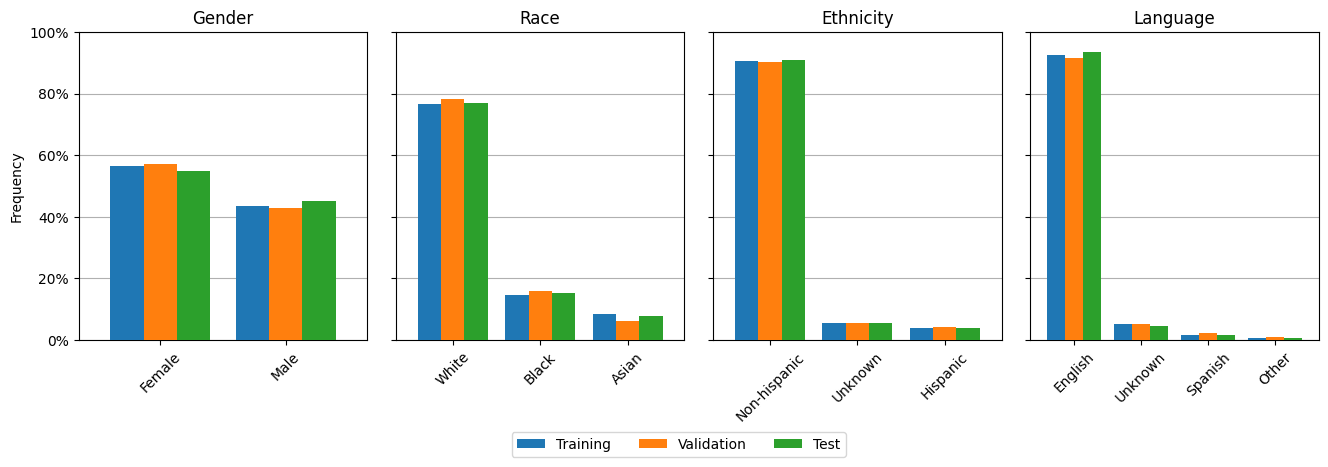

0.9734792675226268
0.9579281183932347


In [54]:
df = pd.read_csv(DATA_DIR / 'Harvard-FairVLMed/data_summary.csv')

# List of categorical attributes to plot
attributes = ['gender', 'race', 'ethnicity', 'language']
df['use'] = pd.Categorical(df['use'], categories=['training', 'validation', 'test'], ordered=True)
# Set up figure and axes
fig, ax = plt.subplots(nrows=1, ncols=len(attributes), figsize=(16, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

handles, labels = None, None

# Iterate over attributes
for idx, attr in enumerate(attributes):
    # Group by `use` and `attr` to calculate frequencies
    grouped = df.groupby(['use', attr]).size().unstack(fill_value=0)

    total_frequencies = grouped.sum(axis=0)
    sorted_categories = total_frequencies.sort_values(ascending=False).index
    grouped = grouped[sorted_categories]

    # Plot grouped bar chart
    normalized = grouped.div(grouped.sum(axis=1), axis=0)

    normalized.T.plot(kind='bar', ax=ax[idx], width=0.8, zorder=3)
    ax[idx].set_ylabel('Frequency')
    ax[idx].set_xlabel('')
    ax[idx].set_title(attr.capitalize())
    ax[idx].grid(axis='y', zorder=1)
    if handles is None and labels is None:
        handles, labels = ax[idx].get_legend_handles_labels()

    x_labels = [label.get_text().capitalize() for label in ax[idx].get_xticklabels()]
    ax[idx].set_xticklabels(x_labels)
    
    ax[idx].get_legend().remove()
    # Format y-axis as percentages
    ax[idx].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax[idx].set_ylim(0, 1)
    ax[idx].tick_params(axis='x', rotation=45)

labels = [label.capitalize() for label in labels]
legend = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3, )

# Save and show plot
plt.savefig('attribute_distribution_all_sets.pdf', bbox_inches='tight')
plt.show()


[]

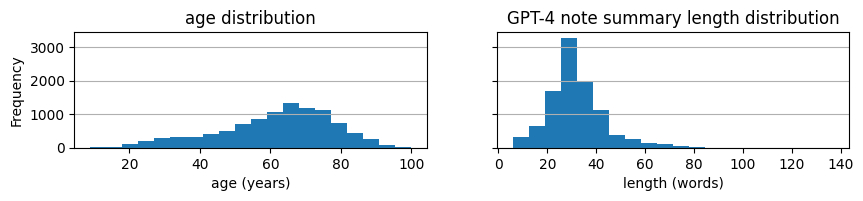

In [55]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(10,1.5), sharey=True)
df.age.plot(ax = ax[0], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'age distribution')
ax[0].set_xlabel('age (years)')
ax[0].grid(axis='y')
notes_length = df['gpt4_summary'].apply(lambda x: len(x.split()))
notes_length.plot(ax = ax[1], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'GPT-4 note summary length distribution')
ax[1].set_xlabel('length (words)')
ax[1].grid(axis='y')
plt.plot()

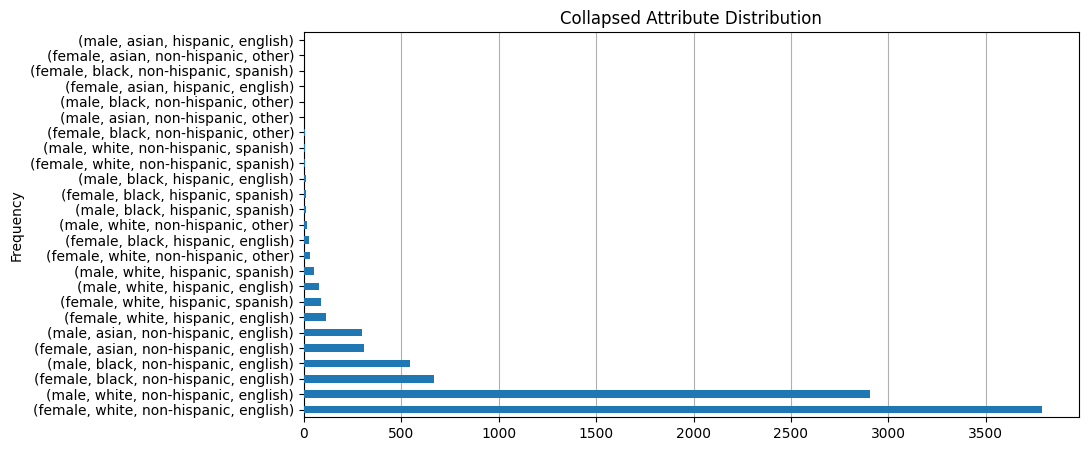

0.9481184591405032
8516 8982
0.7453796481852594
6695 8982
gender  race   ethnicity     language
female  white  non-hispanic  english     3789
male    white  non-hispanic  english     2906
dtype: int64


In [57]:
l1 = ['gender', 'race', 'ethnicity', 'language']
# drop rows where "unknown" is present
df_filtered = df[~df[l1].isin(['unknown']).any(axis=1)]
df_filtered[l1].value_counts().plot(kind = 'barh', xlabel = 'Frequency', ylabel='', title = 'Collapsed Attribute Distribution', figsize = (10,5), zorder=3)
# y axis line
plt.grid(axis='x', zorder=0)
plt.savefig('collapsed_attribute_distribution_1.pdf', bbox_inches='tight')
plt.show()

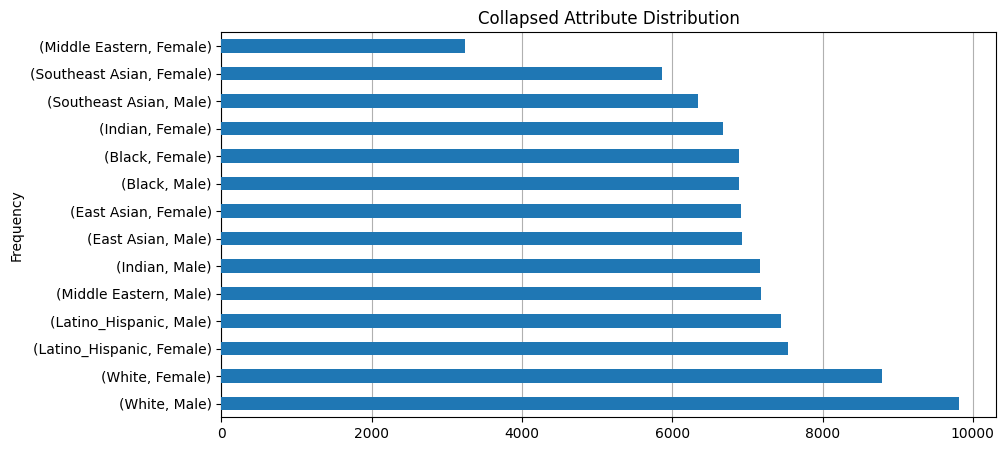

In [19]:
df_fairface_train = pd.read_csv(DATA_DIR / 'fairface/fairface_label_train.csv')
df_fairface_val = pd.read_csv(DATA_DIR / 'fairface/fairface_label_val.csv')
df_fairface = pd.concat([df_fairface_train, df_fairface_val])
df_fairface.value_counts()

l1 = ['race', 'gender']
# drop rows where "unknown" is present
df_filtered = df_fairface[~df_fairface[l1].isin(['unknown']).any(axis=1)]
df_filtered[l1].value_counts().plot(kind = 'barh', xlabel = 'Frequency', ylabel='', title = 'Collapsed Attribute Distribution', figsize = (10,5), logx=False, zorder=3)
# y axis line
plt.grid(axis='x', zorder=0)
plt.savefig('collapsed_attribute_distribution_fairface.pdf', bbox_inches='tight')
plt.show()

The dataset also includes Ophthalmoscopy images, which are used by medical professionals to determine prescence of Glaucoma

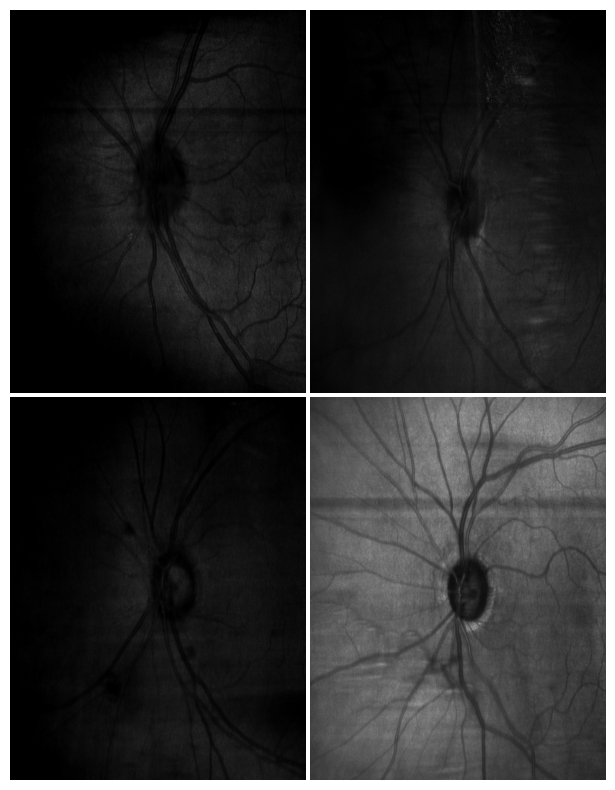

In [8]:
# display images in grid
fig, ax = plt.subplots(2, 2, figsize=(7.7,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
ax[0,0].imshow(plt.imread(DATA_DIR / 'Harvard-FairVLMed/Training/slo_fundus_00001.jpg'))
ax[0,1].imshow(plt.imread(DATA_DIR / 'Harvard-FairVLMed/Training/slo_fundus_00002.jpg'))
ax[1,0].imshow(plt.imread(DATA_DIR / 'Harvard-FairVLMed/Training/slo_fundus_00003.jpg'))
ax[1,1].imshow(plt.imread(DATA_DIR / 'Harvard-FairVLMed/Training/slo_fundus_00004.jpg'))

for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')
fig.show()

## Models & Experiments
  The models are based on the architecture of the CLIP model, this vision language model is trained using contrastive learning with GPT-4 summarised notes and opthalmology images Luo et al. (2024) [[2]](#2). This section will show finetuning of CLIP and FairCLIP+ 
  <html>
<body>
  <!-- Adjust the width and height of the SVG -->
  <img src="framework.svg" alt="Framework Diagram" width="1000" height="500">
</body>
</html>

## Finetuned CLIP

#### Loading the 70% Training and 10% Validation samples

In [19]:
import FairCLIP.src.logger as logger
from FairCLIP.src.modules import *
import os
import numpy as np
import random
import argparse
import time
import json
import pandas as pd
import sys
from collections import Counter

import clip

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from geomloss import SamplesLoss


lr = 0.0001
weight_decay = 0.0001
num_epochs = 10
save_model = False
dataset_dir = 'data/Harvard-FairVLMed'
summarized_note_file='gpt-4_summarized_notes.csv'
text_source = 'note'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading the model, this only needs to be done once
model, preprocess = clip.load(
    'RN50', device=device, jit=False)

train_dataset = fair_vl_med_dataset(dataset_dir, preprocess, subset='Training',
                                    text_source=text_source, summarized_note_file=summarized_note_file)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                                num_workers=0, pin_memory=True, drop_last=False)

val_dataset = fair_vl_med_dataset('data/Harvard-FairVLMed', preprocess, subset='Validation')
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                                 num_workers=0, pin_memory=True, drop_last=False)

logger.log(
    f'# of training samples: {train_dataset.__len__()}, # of testing samples: {val_dataset.__len__()}')

# of training samples: 7000, # of testing samples: 940


#### Training for 10 epochs on a small subset of the data

In [ ]:
columns = [
    'epoch', 'acc', 
    'esacc_attr0', 'esacc_attr1', 'esacc_attr2', 'esacc_attr3', 
    'auc', 
    'esauc_attr0', 'esauc_attr1', 'esauc_attr2', 'esauc_attr3', 
    'auc_attr0_group0', 'auc_attr0_group1', 'auc_attr0_group2', 
    'auc_attr1_group0', 'auc_attr1_group1', 
    'auc_attr2_group0', 'auc_attr2_group1', 
    'auc_attr3_group0', 'auc_attr3_group1', 'auc_attr3_group2', 
    'dpd_attr0', 'dpd_attr1', 'dpd_attr2', 'dpd_attr3', 
    'eod_attr0', 'eod_attr1', 'eod_attr2', 'eod_attr3', 
    'std_group_disparity_attr0', 'max_group_disparity_attr0', 
    'std_group_disparity_attr1', 'max_group_disparity_attr1', 
    'std_group_disparity_attr2', 'max_group_disparity_attr2', 
    'std_group_disparity_attr3', 'max_group_disparity_attr3', 
    'path'
]
df = pd.DataFrame(columns=columns)




def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()


loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {"params": model.transformer.parameters(), "lr": lr},
    {"params": model.visual.parameters(), "lr": lr},
], lr=lr, betas=(0.1, 0.1), eps=1e-6, weight_decay=weight_decay)

best_epoch = 0
best_loss = 1000000
best_auc_groups = None
best_acc_groups = None
best_pred_gt_by_attr = None
best_auc = sys.float_info.min
best_acc = sys.float_info.min
best_es_acc = sys.float_info.min
best_es_auc = sys.float_info.min
best_between_group_disparity = None



for epoch in range(num_epochs):
    avg_loss = 0
    num_batches = 0
    for batch in train_dataloader:
        num_batches += 1
        if visualization_mode:
            if num_batches > 20: 
                break
        optimizer.zero_grad()

        images, texts, label_and_attributes = batch

        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(
            len(images), dtype=torch.long, device=device)

        total_loss = (loss_img(logits_per_image, ground_truth) +
                        loss_txt(logits_per_text, ground_truth))/2
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)
        avg_loss += total_loss.item()
        break

    avg_loss /= len(train_dataloader)

    # iterate over **validation** dataset
    eval_avg_loss = 0
    all_probs = []
    all_labels = []
    all_attrs = []
    for batch in val_dataloader:
        images, texts, label_and_attributes = batch

        images = images.to(device)
        texts = texts.to(device)
        glaucoma_labels = label_and_attributes[:, 0].to(device)
        attributes = label_and_attributes[:, 1:].to(device)

        class_text_feats = []
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=1, keepdim=True)

            for i in range(texts.shape[1]):
                text_features = model.encode_text(texts[:, i, :])
                text_features /= text_features.norm(dim=1, keepdim=True)
                class_text_feats.append(text_features[:, None, :])
            # concatentate class_text_feats along the second dimension
            class_text_feats = torch.cat(class_text_feats, dim=1)

        vl_prob, vl_logits = compute_vl_prob(
            image_features, class_text_feats)

        all_probs.append(vl_prob[:, 1].cpu().numpy())
        all_labels.append(glaucoma_labels.cpu().numpy())
        all_attrs.append(attributes.cpu().numpy())

        # apply binary cross entropy loss
        loss = F.binary_cross_entropy(
            vl_prob[:, 1].float(), glaucoma_labels.float())
        eval_avg_loss += loss.item()

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_attrs = np.concatenate(all_attrs, axis=0)
    eval_avg_loss /= len(val_dataloader)

    logger.log(
        f'===> epoch[{epoch:03d}/{num_epochs:03d}], training loss: {avg_loss:.4f}, eval loss: {eval_avg_loss:.4f}')

    overall_acc, eval_es_acc, overall_auc, eval_es_auc, eval_aucs_by_attrs, eval_dpds, eval_eods, between_group_disparity = evaluate_comprehensive_perf(
        all_probs, all_labels, all_attrs.T)
    
    if best_auc <= overall_auc:
        best_auc = overall_auc
        best_acc = overall_acc
        best_ep = epoch
        best_auc_groups = eval_aucs_by_attrs
        best_dpd_groups = eval_dpds
        best_eod_groups = eval_eods
        best_es_acc = eval_es_acc
        best_es_auc = eval_es_auc
        best_between_group_disparity = between_group_disparity


        if save_model:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': eval_avg_loss,
            }, os.path.join(result_dir, f"clip.pth"))


    # Prepare the CSV string
    row = f'{best_ep}, {round(best_acc, 4)}, ' \
        + ', '.join([f'{x:.4f}' for x in best_es_acc]) + ', ' \
        + f'{best_auc:.4f}, ' \
        + ', '.join([f'{x:.4f}' for x in best_es_auc]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[0]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[1]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[2]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[3]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_dpd_groups]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_eod_groups]) + ', ' \
        + ', '.join([f'{x[0]:.4f}, {x[1]:.4f}' for x in best_between_group_disparity]) + ', ' \
        + 'showcase'

    # Append the row to the DataFrame
    df.loc[len(df)] = row.split(', ')

===> epoch[000/010], training loss: 0.0255, eval loss: 0.6932
===> epoch[001/010], training loss: 0.0169, eval loss: 0.6932
===> epoch[002/010], training loss: 0.0166, eval loss: 0.6932
===> epoch[003/010], training loss: 0.0164, eval loss: 0.6932
===> epoch[004/010], training loss: 0.0165, eval loss: 0.6931
===> epoch[005/010], training loss: 0.0161, eval loss: 0.6931
===> epoch[006/010], training loss: 0.0158, eval loss: 0.6931
===> epoch[007/010], training loss: 0.0159, eval loss: 0.6932


#### Displaying results for training, best epoch is displayed for each completed epoch

In [11]:
display(df)

,epoch,acc,esacc_attr0,esacc_attr1,esacc_attr2,esacc_attr3,auc,esauc_attr0,esauc_attr1,esauc_attr2,...,eod_attr3,std_group_disparity_attr0,max_group_disparity_attr0,std_group_disparity_attr1,max_group_disparity_attr1,std_group_disparity_attr2,max_group_disparity_attr2,std_group_disparity_attr3,max_group_disparity_attr3,path
0,0,0.4926,0.3928,0.4810,0.4408,0.3242,0.4553,0.4257,0.4540,0.4367,...,0.0000,0.0319,0.0748,0.0031,0.0062,0.0468,0.0936,0.0672,0.1425,showcase
1,0,0.4926,0.3928,0.4810,0.4408,0.3242,0.4553,0.4257,0.4540,0.4367,...,0.0000,0.0319,0.0748,0.0031,0.0062,0.0468,0.0936,0.0672,0.1425,showcase
2,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
3,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
4,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
5,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
6,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
7,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
8,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase
9,2,0.5074,0.4047,0.4956,0.4541,0.3340,0.5006,0.4967,0.4948,0.4905,...,0.0000,0.0044,0.0102,0.0116,0.0233,0.0206,0.0412,0.0119,0.0254,showcase


## Training FairCLIP
FairCLIP makes use of a custom loss objective, in which the sinkhorn loss is used to minimize distance between groups based on weights. In this model the weights used attempt to minimize distance for Race and gender. The original FairCLIP model is able to train on a single attribute (race, gender, ethnicity or language), the FairCLIP+ model introduced in our paper allows for a custom combination of attribute importance.

#### Defining the weights

To train the equivalent of the FairCLIP model run with one value set to 1 and the others set to 0, the current settings are the weights used for FairCLIP+

In [12]:
weightslist = [0.5, 0.5, 0, 0]

#### Defining the FairCLIP loss function
FairCLIP uses a custom loss, which loads each subset of data for each group and is able to compute loss for each subgroup.  

In [ ]:
def loss_fairer_CLIP(all_attribute_dataloaders, loss, logits_per_image, logits_per_text, model, device, weightslist):
    total_sinkhorn_loss = 0
    similarity = (logits_per_image @ logits_per_text.T)
    correlations_with_batch = similarity.diag().float()
    total_groups = 0
    for attributeid, group_dataloader in enumerate(all_attribute_dataloaders):
        if weightslist[attributeid] == 0:
            continue
        total_loss = 0
        total_groups += 1
        for x in group_dataloader:
            images_dist, texts_dist, _ = next(x)
            images_dist = images_dist.to(device)
            texts_dist = texts_dist.to(device)
            with torch.no_grad():
                img_feats, txt_feats = model(images_dist, texts_dist)

            similarity = (img_feats @ txt_feats.T)
            correlations_with_group = similarity.diag().float()
            correlations_with_group /= correlations_with_group.sum()

            # REMARK: if correct, this means that attributes with more groups, have more added fairness loss
            total_loss = total_loss + loss(correlations_with_batch[:, None], correlations_with_group[:, None])
        total_sinkhorn_loss += weightslist[attributeid]*total_loss
    return total_sinkhorn_loss/total_groups

groups_in_attrs = [3, 2, 2, 3]
attr_to_idx = {'race': 0, 'gender': 1, 'ethnicity': 2, 'language': 3}
idx_to_attr = {0: 'race', 1: 'gender', 2: 'ethnicity', 3: 'language'}
weightslist = [0.5, 0.5, 0, 0]
accum_iter = 1
sinkhorn_diameter=2
sinkhorn_scaling=0.9
sinkhorn_blur=1e-4
lambda_fairloss=1e-5

all_attribute_dataloaders = []
for attr in range(len(groups_in_attrs)):
    # get different dataloaders for each group inside an attribute (for example: male, female; or: English, Spanish)
    group_dataloaders = []
    for i in range(groups_in_attrs[attr]):
        tmp_dataset = fair_vl_group_dataset(dataset_dir, preprocess,
                                            text_source='note', summarized_note_file=summarized_note_file,
                                            attribute=idx_to_attr[attr], thegroup=i)
        tmp_dataloader = DataLoader(tmp_dataset, batch_size=32, shuffle=True,
                                    num_workers=0, pin_memory=True, drop_last=False)
        group_dataloaders.append(endless_loader(tmp_dataloader))
    all_attribute_dataloaders.append(group_dataloaders)

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {"params": model.transformer.parameters(), "lr": lr},
    {"params": model.visual.parameters(), "lr": lr},
], lr=lr, betas=(0.1, 0.1), eps=1e-6, weight_decay=weight_decay)

loss_for_FairCLIP = SamplesLoss(
        loss="sinkhorn", p=2, blur=sinkhorn_blur)


#### Training the FairCLIP model on a custom subset of the data

In [14]:
model.float()
best_epoch = 0
best_loss = 1000000
best_auc_groups = None
best_acc_groups = None
best_pred_gt_by_attr = None
best_auc = sys.float_info.min
best_acc = sys.float_info.min
best_es_acc = sys.float_info.min
best_es_auc = sys.float_info.min
best_between_group_disparity = None

df_fairer_clip = pd.DataFrame(columns=columns)


for epoch in range(num_epochs):
    avg_loss = 0
    num_batches = 0
    for batch_idx, batch in enumerate(train_dataloader):
        num_batches += 1
        if visualization_mode:
            if num_batches > 10: 
                break
        optimizer.zero_grad()

        images, texts, label_and_attributes = batch

        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(
            len(images), dtype=torch.long, device=device)

        total_loss = (loss_img(logits_per_image, ground_truth) +
                        loss_txt(logits_per_text, ground_truth))/2

        total_sinkhorn_loss = loss_fairer_CLIP(all_attribute_dataloaders, loss_for_FairCLIP, logits_per_image, logits_per_text, model, device, weightslist)

        total_loss += lambda_fairloss * total_sinkhorn_loss

        total_loss /= accum_iter

        total_loss.backward()

        avg_loss += total_loss.item()
        
        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
            optimizer.step()
            optimizer.zero_grad()

    avg_loss /= len(train_dataloader)

    # iterate over test dataset
    eval_avg_loss = 0
    all_probs = []
    all_labels = []
    all_attrs = []
    for batch in val_dataloader:
        images, texts, label_and_attributes = batch

        images = images.to(device)
        texts = texts.to(device)
        glaucoma_labels = label_and_attributes[:, 0].to(device)
        attributes = label_and_attributes[:, 1:].to(device)

        class_text_feats = []
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=1, keepdim=True)

            for i in range(texts.shape[1]):
                text_features = model.encode_text(texts[:, i, :])
                text_features /= text_features.norm(dim=1, keepdim=True)
                class_text_feats.append(text_features[:, None, :])
            # concatentate class_text_feats along the second dimension
            class_text_feats = torch.cat(class_text_feats, dim=1)

        vl_prob, vl_logits = compute_vl_prob(
            image_features, class_text_feats)

        all_probs.append(vl_prob[:, 1].cpu().numpy())
        all_labels.append(glaucoma_labels.cpu().numpy())
        all_attrs.append(attributes.cpu().numpy())

        # apply binary cross entropy loss
        loss = F.binary_cross_entropy(
            vl_prob[:, 1].float(), glaucoma_labels.float())
        eval_avg_loss += loss.item()

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_attrs = np.concatenate(all_attrs, axis=0)
    eval_avg_loss /= len(val_dataloader)
    
    logger.log(
        f'===> epoch[{epoch:03d}/{num_epochs:03d}], training loss: {avg_loss:.4f}, eval loss: {eval_avg_loss:.4f}')

    overall_acc, eval_es_acc, overall_auc, eval_es_auc, eval_aucs_by_attrs, eval_dpds, eval_eods, between_group_disparity = evaluate_comprehensive_perf(
        all_probs, all_labels, all_attrs.T)
    
    if best_auc <= overall_auc:
        best_auc = overall_auc
        best_acc = overall_acc
        best_ep = epoch
        best_auc_groups = eval_aucs_by_attrs
        best_dpd_groups = eval_dpds
        best_eod_groups = eval_eods
        best_es_acc = eval_es_acc
        best_es_auc = eval_es_auc
        best_between_group_disparity = between_group_disparity


        if save_model:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': eval_avg_loss,
            }, os.path.join(result_dir, f"clip.pth"))


    # Prepare the CSV string
    row = f'{best_ep}, {round(best_acc, 4)}, ' \
        + ', '.join([f'{x:.4f}' for x in best_es_acc]) + ', ' \
        + f'{best_auc:.4f}, ' \
        + ', '.join([f'{x:.4f}' for x in best_es_auc]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[0]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[1]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[2]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_auc_groups[3]]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_dpd_groups]) + ', ' \
        + ', '.join([f'{x:.4f}' for x in best_eod_groups]) + ', ' \
        + ', '.join([f'{x[0]:.4f}, {x[1]:.4f}' for x in best_between_group_disparity]) + ', ' \
        + 'showcase'

    # Append the row to the DataFrame
    df_fairer_clip.loc[len(df_fairer_clip)] = row.split(', ')

===> epoch[000/010], training loss: 6.6707, eval loss: 0.6932
===> epoch[001/010], training loss: 1.2695, eval loss: 0.6931
===> epoch[002/010], training loss: 0.6109, eval loss: 0.6931
===> epoch[003/010], training loss: 1.0092, eval loss: 0.6931
===> epoch[004/010], training loss: 0.2789, eval loss: 0.6931
===> epoch[005/010], training loss: 0.1604, eval loss: 0.6931
===> epoch[006/010], training loss: 0.2955, eval loss: 0.6931
===> epoch[007/010], training loss: 0.2289, eval loss: 0.6931
===> epoch[008/010], training loss: 0.2004, eval loss: 0.6931
===> epoch[009/010], training loss: 0.2000, eval loss: 0.6931


#### Displaying results for training, best epoch is displayed for each completed epoch

In [15]:
display(df_fairer_clip)

,epoch,acc,esacc_attr0,esacc_attr1,esacc_attr2,esacc_attr3,auc,esauc_attr0,esauc_attr1,esauc_attr2,...,eod_attr3,std_group_disparity_attr0,max_group_disparity_attr0,std_group_disparity_attr1,max_group_disparity_attr1,std_group_disparity_attr2,max_group_disparity_attr2,std_group_disparity_attr3,max_group_disparity_attr3,path
0,0,0.4926,0.3928,0.4810,0.4408,0.3242,0.4978,0.4493,0.4880,0.4825,...,0.0000,0.0267,0.0655,0.0201,0.0402,0.0318,0.0636,0.1493,0.3174,showcase
1,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
2,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
3,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
4,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
5,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
6,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
7,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
8,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase
9,1,0.4926,0.3928,0.4810,0.4408,0.3242,0.5738,0.5333,0.5706,0.5251,...,0.0000,0.0353,0.0805,0.0050,0.0100,0.0808,0.1615,0.0893,0.1960,showcase


To run this experiment please make sure to pretrain CLIP using the previously shown pretraining, as well as have access to a GPU

In [9]:
import sys
import argparse
import mae.main_linprobe as linprobe

args_clip = argparse.Namespace(
    model_type="clip",  # ${MODEL_TYPE}
    vl_feats_type="image",  # ${FEATS_TYPE}
    vision_encoder_weights="clip",
    summary_type="gpt-4",  # ${SUMMARY_TYPE}
    batch_size=512,  # ${BATCH_SIZE}
    model="vit_large_patch16",
    cls_token=True,
    finetune="ViT-L/14",  # ${PRETRAIN_CHKPT}
    save_checkpoint_name="CLIP_seed1542",  # ${CHKPT_NAME}
    epochs=500,  # ${EPOCHS}
    blr=0.1,  # ${LR}
    weight_decay=0.0,  # ${WDECAY}
    data_path="data/Harvard-FairVLMed",  # ${DATA_DIR}
    output_dir="../results/linear_probing",  # ${EXP_NAME}
    log_dir="../results/linear_probing",  # ${EXP_NAME}
    nb_classes=2,
    blip_feats_select="avgpool",
    cfg_path="../LAVIS/lavis/projects/blip2/train/pretrain_stage1.yaml",  # ${CFG_PATH}
    seed=2795,  # ${SEED}
    device="cuda",  # ${DEVICE}
    dist_eval=False,
    eval=False,
    num_workers=0,
    pin_mem=False,
    global_pool="avg",
    accum_iter=1,
    start_epoch=0,  # Default: 0
    resume="",  # Default: '' (empty string for no checkpoint)
    min_lr=0.0,  # Default: 0.0
    warmup_epochs=10,  # Default: 10
    dist_on_itp=False,  # Default: False
    dist_url="env://",  # Default: 'env://'
    world_size=1,  # Default: 1
    local_rank=-1,  # Default: -1
    options=None,  # Default: None (as it’s `nargs="+`)
    lr=0.0001,
)

args_clip_ft = argparse.Namespace(
    model_type="clip",  # ${MODEL_TYPE}
    vl_feats_type="image",  # ${FEATS_TYPE}
    vision_encoder_weights="clip",
    summary_type="gpt-4",  # ${SUMMARY_TYPE}
    batch_size=512,  # ${BATCH_SIZE}
    model="vit_large_patch16",
    cls_token=True,
    finetune="ViT-L/14",  # ${PRETRAIN_CHKPT}
    save_checkpoint_name="CLIP_seed1542",  # ${CHKPT_NAME}
    epochs=500,  # ${EPOCHS}
    blr=0.1,  # ${LR}
    weight_decay=0.0,  # ${WDECAY}
    data_path="data/Harvard-FairVLMed",  # ${DATA_DIR}
    output_dir="../results/linear_probing",  # ${EXP_NAME}
    log_dir="../results/linear_probing",  # ${EXP_NAME}
    nb_classes=2,
    blip_feats_select="avgpool",
    cfg_path="../LAVIS/lavis/projects/blip2/train/pretrain_stage1.yaml",  # ${CFG_PATH}
    seed=2795,  # ${SEED}
    device="cuda",  # ${DEVICE}
    dist_eval=False,
    eval=False,
    num_workers=0,
    pin_mem=False,
    global_pool="avg",
    accum_iter=1,
    start_epoch=0,  # Default: 0
    resume="",  # Default: '' (empty string for no checkpoint)
    min_lr=0.0,  # Default: 0.0
    warmup_epochs=10,  # Default: 10
    dist_on_itp=False,  # Default: False
    dist_url="env://",  # Default: 'env://'
    world_size=1,  # Default: 1
    local_rank=-1,  # Default: -1
    options=None,  # Default: None (as it’s `nargs="+`)
    lr=0.0001,
)


if not visualization_mode:
    linprobe.main(args_clip)
    linprobe.main(args_clip_ft)

We can also load in results from an example run, as shown below.

In [10]:
def get_results(df_results, order):
    columns = df_results.columns
    # get columns containing esacc
    race_columns = [col for col in columns if 'attr0' in col]
    gender_columns = [col for col in columns if 'attr1' in col]
    ethnicity_columns = [col for col in columns if 'attr2' in col]
    language_columns = [col for col in columns if 'attr3' in col]

    df_results_race = df_results[race_columns].copy()
    df_results_gender = df_results[gender_columns].copy()
    df_results_ethnicity = df_results[ethnicity_columns].copy()
    df_results_language = df_results[language_columns].copy()

    grouped_params = [(race_columns, df_results_race, 'attr0', 'Race'), (gender_columns, df_results_gender, 'attr1', 'Gender'), (ethnicity_columns, df_results_ethnicity, 'attr2', 'Ethnicity'), (language_columns, df_results_language, 'attr3', 'Language')]

    # get mean and standard deviation for each column and add to df with appended name
    for (esacc_columns, partial_df, attr_idx, attr_name) in grouped_params:
        for col in esacc_columns:
            mean = partial_df[col].mean()*100
            std = partial_df[col].std()*100
            colname = col.replace('_' + attr_idx, '').replace('eval_', '').strip()
            partial_df.loc[:, colname + '_mean'] = mean
            partial_df.loc[:, colname + '_std'] = std
            partial_df.drop(columns=[col], inplace=True)
        partial_df.insert(0, 'Attribute', attr_name)

        if "  auc" in df_results:
            partial_df.insert(0, 'auc_mean', df_results['  auc'].mean())
            partial_df.insert(0, 'auc_std', df_results['  auc'].std())
        else:
            partial_df.insert(0, 'auc_mean', df_results['auc'].mean())
            partial_df.insert(0, 'auc_std', df_results['auc'].std())
        partial_df.drop_duplicates(inplace=True)
        if attr_name == 'Race':
            df_results_final = partial_df.copy()
        else:
            df_results_final = pd.concat([df_results_final, partial_df], ignore_index=True)

    # add column Attribute with value Race
    df_results_final.fillna(' ', inplace=True)


    # reorder columns
    df_results_final = df_results_final[order]
    # round auc mean and std to 2 decimals
    df_results_final['auc_mean'] = df_results_final['auc_mean'].mean()*100
    df_results_final['auc_std'] = df_results_final['auc_std'].mean()*100

    return df_results_final

def print_results_latex(df_results_final, order):
    attributes = df_results_final['Attribute'].unique()
    attributes = list(attributes)
    n_models = len(df_results_final['Model'].unique())
    
    print(f"Order of attributes: {attributes}\n")
    
    for attribute in attributes:
        df_results_final_slice = df_results_final[df_results_final['Attribute'] == attribute]
        for x in range(n_models):
            # order the slice
            df_results_final_ordered_slice = df_results_final_slice[order]
            # print(df_results_final_ordered_slice)
            # store row 1 as list
            row1 = df_results_final_ordered_slice.iloc[x].values.tolist()
            results = []
            for i in range(len(row1)-1):
                if i % 2 == 0:
                    # if row1[i+1] is empty add empty string
                    if row1[i+1] == ' ':
                        results.append(' ')
                    # if row1[i+1] is highest value boldface
                    elif row1[i+1] == max(df_results_final_ordered_slice.iloc[:, i+1]) and df_results_final_ordered_slice.columns[i+1] not in ['dpd_mean', 'eod_mean']:
                        results.append('\\textbf{' + f"{row1[i+1]:.2f}" + '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}")
                    elif row1[i+1] == min(df_results_final_ordered_slice.iloc[:, i+1]) and df_results_final_ordered_slice.columns[i+1] in ['dpd_mean', 'eod_mean']:
                        results.append('\\textbf{' + f"{row1[i+1]:.2f}" + '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}")
                    # if second highest, underline
                    elif row1[i+1] == sorted(df_results_final_ordered_slice.iloc[:, i+1])[-2] and df_results_final_ordered_slice.columns[i+1] not in ['dpd_mean', 'eod_mean']:
                        results.append('\\underline{' + f"{row1[i+1]:.2f}"+ '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}" )
                    elif row1[i+1] == sorted(df_results_final_ordered_slice.iloc[:, i+1])[1] and df_results_final_ordered_slice.columns[i+1] in ['dpd_mean', 'eod_mean']:
                        results.append('\\underline{' + f"{row1[i+1]:.2f}"+ '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}" )
                    else:
                        results.append(f"{row1[i+1]:.2f}" + ' $\pm$ ' + f"{row1[i+2]:.2f}")
            # get model name idx x and attribute = Attribute, value model_name
            model_name = df_results_final_slice.iloc[x]['Model']
            print( ' & ' + model_name + ' & ' +' & '.join(results) + ' \\\\')
        print()


def create_full_table(csv_paths, order):
    df_results_final = None
    
    for path, model_name in csv_paths:
        df_output = pd.read_csv(path)#.loc[3:]
        df_results = get_results(df_output, order)
        # add model name to df
        df_results.insert(0, 'Model', model_name)

        if df_results_final is None:
            df_results_final = df_results.copy()
        else:
            df_results_final = pd.concat([df_results_final, df_results], ignore_index=True)
    return df_results_final


def create_full_table_singular(path, name_path_mapping):
    order = ['Attribute', 'dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']

    df_results_final = None
    df_output = pd.read_csv(path)

    for name, paths in name_path_mapping.items():
        df_results = get_results(df_output[df_output["path"].isin(paths)], order)
        df_results.insert(0, 'Model', name)

        if df_results_final is None:
            df_results_final = df_results.copy()
        else:
            df_results_final = pd.concat([df_results_final, df_results], ignore_index=True)
    
    return df_results_final

df_results_final = create_full_table_singular(
    path= RESULTS_DIR / 'lp_results.csv',
    name_path_mapping={
        "CLIP": ['CLIP_seed1542', 'CLIP_seed2859', 'CLIP_seed3231'],
        "CLIP-FT": ['CLIP_FT_seed2795', 'CLIP_FT_seed2859', 'CLIP_FT_seed3231']
    }
)
order = ['Attribute', 'dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']

display(df_results_final)

,Model,Attribute,dpd_mean,dpd_std,eod_mean,eod_std,auc_mean,auc_std,esauc_mean,esauc_std,auc_group0_mean,auc_group0_std,auc_group1_mean,auc_group1_std,auc_group2_mean,auc_group2_std
0,CLIP,Race,5.343780,0.654469,9.628019,0.965709,76.530975,0.084571,71.496938,0.316869,79.896104,0.375302,73.249390,0.493998,76.926538,0.153157
1,CLIP,Gender,0.355673,0.147484,4.443389,0.547711,76.530975,0.084571,71.700864,0.066963,73.474157,0.025092,80.210750,0.196091,,
2,CLIP,Ethnicity,18.467412,1.182737,19.937470,1.510994,76.530975,0.084571,71.195290,0.240811,76.743021,0.098689,69.247685,0.364721,,
3,CLIP,Language,21.550388,2.772334,30.615942,7.216878,76.530975,0.084571,71.826780,0.143929,76.431967,0.095943,81.628788,0.328040,75.178284,0.347358
4,CLIP-FT,Race,2.603310,1.238253,10.159420,3.793200,78.961531,2.872077,75.671892,4.034293,81.165945,1.416989,77.336239,2.603710,79.549796,2.90106
5,CLIP-FT,Gender,1.558628,1.572930,6.536466,1.266695,78.961531,2.872077,74.826533,2.236054,76.435705,2.509287,81.951243,3.367376,,
6,CLIP-FT,Ethnicity,13.619792,1.961672,17.881193,1.072790,78.961531,2.872077,72.998793,4.600040,79.266578,2.774235,70.972222,5.773920,,
7,CLIP-FT,Language,9.687071,3.551790,22.583999,7.008632,78.961531,2.872077,69.116720,1.813274,79.450545,2.996128,79.356061,1.640200,67.149758,1.741812


## Performance of linear probe on visual encodings of CLIP after finetuning for 500 epochs

In [5]:
import matplotlib.pyplot as plt

finetuning_results_clip = df_results_final[df_results_final.Model == 'CLIP']
finetuning_results_clip_ft = df_results_final[df_results_final.Model == 'CLIP-FT']
finetuning_results_clip_ft.reset_index(drop=True, inplace=True)

/tmp/ipykernel_9201/416159895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuning_results_clip['Model_Type'] = 'CLIP'
/tmp/ipykernel_9201/416159895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetuning_results_clip_ft['Model_Type'] = 'CLIP-FT'


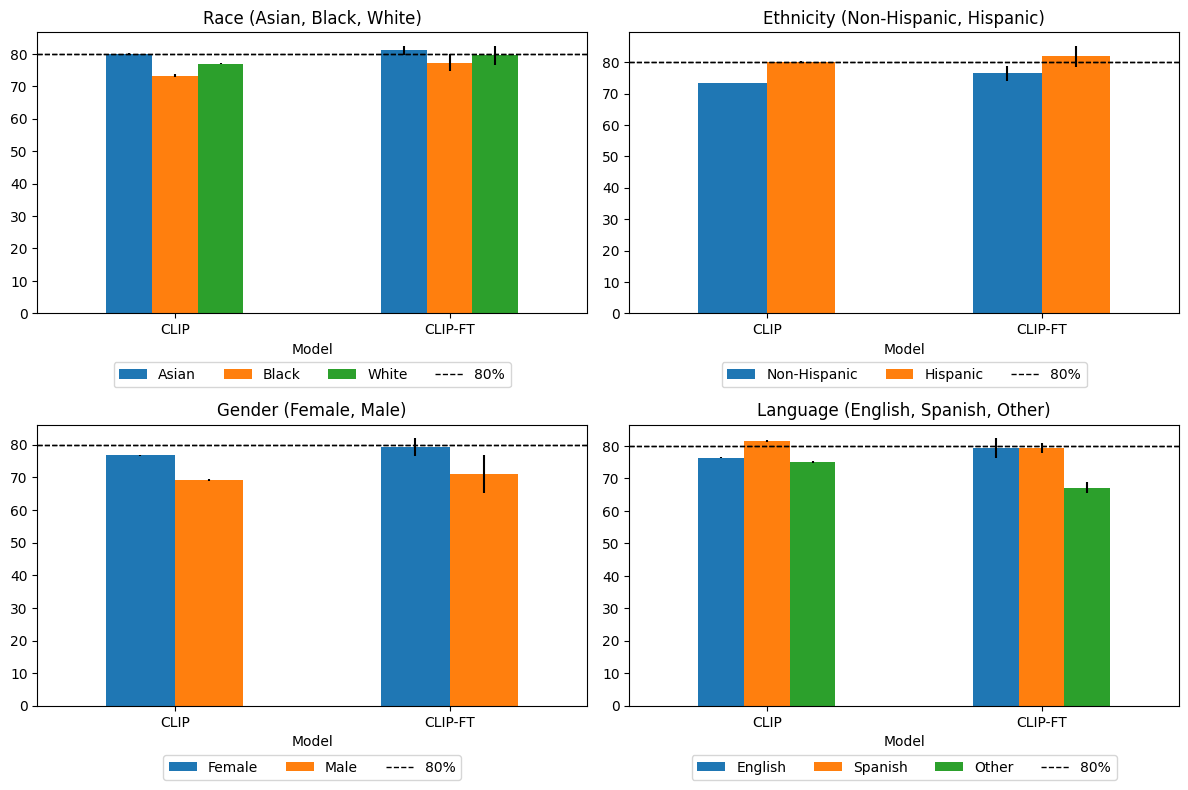

In [6]:
# Add a new column 'Model_Type' to distinguish between CLIP and CLIP-FT
finetuning_results_clip['Model_Type'] = 'CLIP'
finetuning_results_clip_ft['Model_Type'] = 'CLIP-FT'

# Combine the dataframes
combined_results = pd.concat([finetuning_results_clip, finetuning_results_clip_ft])

# Demographic categories and corresponding row indices in the dataframe
demographics = [
    ('Race (Asian, Black, White)', ['auc_group0_mean', 'auc_group1_mean', 'auc_group2_mean'], [0], ['Asian', 'Black', 'White']),
    ('Ethnicity (Non-Hispanic, Hispanic)', ['auc_group0_mean', 'auc_group1_mean'], [1], ['Non-Hispanic', 'Hispanic']),
    ('Gender (Female, Male)', ['auc_group0_mean', 'auc_group1_mean'], [2], ['Female', 'Male']),
    ('Language (English, Spanish, Other)', ['auc_group0_mean', 'auc_group1_mean', 'auc_group2_mean'], [3], ['English', 'Spanish', 'Other'])
]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Adjusted size for clarity

# Loop through demographics to create each plot
for i, (title, auc_columns, idx, legend_labels) in enumerate(demographics):
    # Filter data for the specific demographic category
    finetuning_results_part = combined_results.loc[combined_results.index.isin(idx)]
    
    # Plotting both CLIP and CLIP-FT for the demographic category
    finetuning_results_part.plot(
        x='Model',
        y=auc_columns,  # AUC means to plot
        kind='bar',
        yerr=finetuning_results_part[[f'{col[:-5]}_std' for col in auc_columns]].values.T,  # Corrected std columns
        ax=ax[i//2, i%2],  # Assigning to appropriate subplot
        title=title,
        legend=False  # We'll manually update the legend below
    )

    ax[i//2, i%2].axhline(y=80, linestyle='dashed', color='black', linewidth=1)
    
    # Now update the legend manually to reflect the correct demographic group names
    handles, labels = ax[i//2, i%2].get_legend_handles_labels()
    new_labels = []
    for group in legend_labels:
        new_labels.append(f'{group}')  # Append demographic group name to the label

    # add 80% line to legend
    new_labels.append('80%')
    handles.append(ax[i//2, i%2].axhline(y=80, linestyle='dashed', color='black', linewidth=1))

    
    ax[i//2, i%2].legend(handles, new_labels,loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Update the legend with the new labels
    # rotate xticks
    ax[i//2, i%2].set_xticklabels(ax[i//2, i%2].get_xticklabels(), rotation=0)    

# Final adjustments
plt.tight_layout()  # Ensures subplots don't overlap
plt.show()


In [7]:
finetuning_results_clip = df_results_final[df_results_final.Model == 'CLIP']
finetuning_results_clip_ft = df_results_final[df_results_final.Model == 'CLIP-FT']

exauc = finetuning_results_clip.esauc_mean.mean()
esauc_ft  = finetuning_results_clip_ft.esauc_mean.mean()

print(f"CLIP ES-AUC: {exauc:.2f}")
print(f"CLIP-FT ES-AUC: {esauc_ft:.2f}")

print(f'Difference in ES-AUC between CLIP and CLIP-FT: {esauc_ft - exauc:.2f}')

auc = finetuning_results_clip.auc_mean.mean()
auc_ft  = finetuning_results_clip_ft.auc_mean.mean()

print(f"CLIP AUC: {auc:.2f}")
print(f"CLIP-FT AUC: {auc_ft:.2f}")

print(f'Difference in AUC between CLIP and CLIP-FT: {auc_ft - auc:.2f}')

CLIP ES-AUC: 71.55
CLIP-FT ES-AUC: 73.15
Difference in ES-AUC between CLIP and CLIP-FT: 1.60
CLIP AUC: 76.53
CLIP-FT AUC: 78.96
Difference in AUC between CLIP and CLIP-FT: 2.43


## Sinkhorn Distance Analysis

The Sinkhorn distance was analysed to investigate the correlation between fairness and performance versus reduction of distance between groups

#### To run the code below make sure to have trained the relevant FairCLIP model

In [29]:
DATASET_DIR = "data/Harvard-FairVLMed"
MODEL_ARCH = "vit-b16"
BATCH_SIZE = 32
SEED = 42
# Replace this with your relevant checkpoint! 
CHECKPOINT = "results/fairCLIP/language/glaucoma_FairCLIP_vit-b16_327482_seed7482_auc0.6513/clip.pth"
OUT = "distances.pickle"

if not visualization_mode:
    !python experiments/distance_test.py \
        --seed {SEED} \
        --batch_size {BATCH_SIZE} \
        --model_arch {MODEL_ARCH} \
        --dataset_dir {DATASET_DIR} \
        --checkpoint {CHECKPOINT} \
        --out {OUT}



We can also load example results:

In [72]:
import pickle

IDX_TO_GROUP = {
    0: {0: "asian", 1: "black", 2: "white"},
    1: {0: "female", 1: "male"},
    2: {0: "non-hispanic", 1: "hispanic"},
    3: {0: "english", 1: "spanish", 2: "other"}
}

with open('FairCLIP/distances_language_example_2.pickle', 'rb') as f:
    distances = pickle.load(f)


data = []
for (group, subgroup), value in distances['distances'].items():
    group_name = IDX_TO_GROUP[group][subgroup]
    data.append([group, subgroup, group_name, value.detach().numpy()])

df = pd.DataFrame(data, columns=["Attr Index", "Group Index", "Group Name", "Sinkhorn_Distances"])

# sort by attr index, then group index
df.sort_values(["Attr Index", "Group Index"], inplace=True)

with open('FairCLIP/distances_fairerclip_example_2.pickle', 'rb') as f:
    distances = pickle.load(f)

data = []
for (group, subgroup), value in distances['distances'].items():
    group_name = IDX_TO_GROUP[group][subgroup]
    data.append([group, subgroup, value.detach().numpy()])

df2 = pd.DataFrame(data, columns=["Attr Index", "Group Index", "Sinkhorn_Distances"])

merge_df = pd.merge(df, df2, on=["Attr Index", "Group Index"], suffixes=["_FairCLIP", "_FairerCLIP"])

# also merge distances clip-ft and clip

with open('FairCLIP/distances_clip_example_2.pickle', 'rb') as f:
    distances = pickle.load(f)

data = []

for (group, subgroup), value in distances['distances'].items():
    group_name = IDX_TO_GROUP[group][subgroup]
    data.append([group, subgroup, value.detach().numpy()])

df = pd.DataFrame(data, columns=["Attr Index", "Group Index", "Sinkhorn_Distances_CLIP"])

# sort by attr index, then group index
df.sort_values(["Attr Index", "Group Index"], inplace=True)

with open('FairCLIP/distances_clip-ft_example_2.pickle', 'rb') as f:
    distances = pickle.load(f)
    
data = []

for (group, subgroup), value in distances['distances'].items():
    group_name = IDX_TO_GROUP[group][subgroup]
    data.append([group, subgroup, value.detach().numpy()])

df2 = pd.DataFrame(data, columns=["Attr Index", "Group Index", "Sinkhorn_Distances-CLIP-FT"])

# merge all dfs with merge_df

merge_df_2 = pd.merge(merge_df, df, on=["Attr Index", "Group Index"], suffixes=["", ''])
merge_df = pd.merge(merge_df_2, df2, on=["Attr Index", "Group Index"], suffixes=["", ""])
display(merge_df)

,Attr Index,Group Index,Group Name,Sinkhorn_Distances_FairCLIP,Sinkhorn_Distances_FairerCLIP,Sinkhorn_Distances_CLIP,Sinkhorn_Distances-CLIP-FT
0,0,0,asian,28.47589,4.7247257,3103.0586,4782.032
1,0,1,black,77.038216,16.726679,1502.6997,14580.836
2,0,2,white,0.19856125,0.06385558,69.27534,2.7962742
3,1,0,female,0.34052604,0.22645536,706.4555,19.515898
4,1,1,male,6.411296,2.2590163,117.712135,476.3388
5,2,0,non-hispanic,0.4239212,0.66772974,8.4751,36.591743
6,2,1,hispanic,45.816326,15.3445835,34478.9,2768.156
7,3,0,english,0.023650084,0.011966035,5.123475,43.817295
8,3,1,spanish,240.90413,55.88095,63284.914,51397.918
9,3,2,other,143.79506,23.901705,20176.545,9777.827


## References
<a id="1">[1]</a> 
https://ophai.hms.harvard.edu/datasets/harvard-fairvlmed10k

<a id="2">[2]</a> 
Luo, Y., Shi, M., Khan, M. O., Afzal, M. M., Huang, H., Yuan, S., ... & Wang, M. (2024). Fairclip: Harnessing fairness in vision-language learning. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 12289-12301).